<a href="https://colab.research.google.com/github/HimankPatidar/AnimalCNN/blob/main/AnimalCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alessiocorrado99_animals10_path = kagglehub.dataset_download('alessiocorrado99/animals10')

print('Data source import complete.')


Data source import complete.


In [70]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


In [71]:
data_dir = alessiocorrado99_animals10_path
data_dir

'/kaggle/input/animals10'

In [72]:
os.listdir(data_dir)

['translate.py', 'raw-img']

In [73]:
height = 224
width = 224


class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img


In [74]:
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((height, width)),
    transforms.ToTensor()
])

print(transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [75]:
dataset = datasets.ImageFolder(root=data_dir, transform = transform)
print("Image size", dataset[0][0].shape)
print("Label", dataset[0][1])


Image size torch.Size([3, 224, 224])
Label 0


In [76]:
from collections import Counter
from tqdm import tqdm

counts = Counter(x[1] for x in tqdm(dataset))
print("The counts dictionary:", counts)

print("The class_to_idx dictionary:", dataset.class_to_idx)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

class_distribution = {idx_to_class[idx]: count for idx, count in counts.items()}
print(class_distribution)


100%|██████████| 26179/26179 [02:46<00:00, 157.26it/s]

The counts dictionary: Counter({0: 26179})
The class_to_idx dictionary: {'raw-img': 0}
{'raw-img': 26179}


In [77]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")


Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


In [78]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    std = torch.sqrt((channels_squared_sum / num_batches) - mean**2)

    return mean, std

mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")


100%|██████████| 819/819 [01:25<00:00,  9.58it/s]

Mean: tensor([0.5177, 0.5003, 0.4125])
Standard deviation: tensor([0.2659, 0.2609, 0.2784])


In [79]:
transform_norm = transforms.Compose(
    [
    ConvertToRGB(),
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std= std)
    ]
)
print(transform_norm)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.5177, 0.5003, 0.4125]), std=tensor([0.2659, 0.2609, 0.2784]))
)


In [80]:
norm_dataset = datasets.ImageFolder(root = data_dir, transform = transform_norm)
print("Image size", norm_dataset[0][0].shape)
print("Label", norm_dataset[0][1])


Image size torch.Size([3, 224, 224])
Label 0


In [81]:

g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2], generator=g)

print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

Training data set size: 20944
Validation data set size: 5235


In [82]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

## Build Model

In [93]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d(2))

conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d(2))

conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d(2))

conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
model.append(conv4)
model.append(torch.nn.ReLU())
model.append(torch.nn.MaxPool2d(2))

# Classifier layers
model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

# Updated Linear layer with correct dimensions
linear1 = torch.nn.Linear(in_features=256*14*14, out_features=512)  # Updated calculation
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(512, 8)
model.append(output_layer)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=50176, out_features=512, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=512, out_features=8, bias=True)
)

In [84]:
!pip install torchinfo

In [85]:
from torchinfo import summary

batch_size = 32
height, width = 224, 224

summary(model, input_size=(batch_size, 3, height, width))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 32, 224, 224]        896
├─ReLU: 1-2                              [32, 32, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 32, 112, 112]        --
├─Conv2d: 1-4                            [32, 64, 112, 112]        18,496
├─ReLU: 1-5                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 64, 56, 56]          --
├─Conv2d: 1-7                            [32, 128, 56, 56]         73,856
├─ReLU: 1-8                              [32, 128, 56, 56]         --
├─MaxPool2d: 1-9                         [32, 128, 28, 28]         --
├─Conv2d: 1-10                           [32, 256, 28, 28]         295,168
├─ReLU: 1-11                             [32, 256, 28, 28]         --
├─MaxPool2d: 1-12                        [32, 256, 14, 14]         --
├

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=50176, out_features=512, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=512, out_features=10, bias=True)
)

In [95]:
print(f"Dataset classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")

num_classes = len(dataset.classes)
model[-1] = torch.nn.Linear(512, num_classes)

Dataset classes: 10
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [88]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc='Training', leave=False):
        # Move images and labels to the specified device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [89]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation', leave=False):
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [107]:
epochs = 10
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("Starting training...")
print("=" * 60)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print epoch results
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_wildlife_model.pth')
        print(f'New best model saved! Val Acc: {val_acc:.2f}%')

    print('-' * 60)

print(f'Training completed! Best validation accuracy: {best_val_acc:.2f}%')

Starting training...
Epoch 1/10


Train Loss: 1.8637, Train Acc: 34.17%
Val Loss: 1.5039, Val Acc: 48.12%
New best model saved! Val Acc: 48.12%
------------------------------------------------------------
Epoch 2/10


Train Loss: 1.4175, Train Acc: 51.51%
Val Loss: 1.1865, Val Acc: 60.21%
New best model saved! Val Acc: 60.21%
------------------------------------------------------------
Epoch 3/10


Train Loss: 1.2037, Train Acc: 58.97%
Val Loss: 1.0647, Val Acc: 63.90%
New best model saved! Val Acc: 63.90%
------------------------------------------------------------
Epoch 4/10


Train Loss: 1.0568, Train Acc: 63.97%
Val Loss: 0.9946, Val Acc: 66.48%
New best model saved! Val Acc: 66.48%
------------------------------------------------------------
Epoch 5/10


Train Loss: 0.9228, Train Acc: 68.38%
Val Loss: 0.9082, Val Acc: 69.57%
New best model saved! Val Acc: 69.57%
------------------------------------------------------------
Epoch 6/10


Train Loss: 0.8095, Train Acc: 72.16%
Val Loss: 0.8976, Val Acc: 70.09%
New best model saved! Val Acc: 70.09%
------------------------------------------------------------
Epoch 7/10


Train Loss: 0.7149, Train Acc: 75.75%
Val Loss: 0.8435, Val Acc: 72.17%
New best model saved! Val Acc: 72.17%
------------------------------------------------------------
Epoch 8/10


Train Loss: 0.6294, Train Acc: 78.34%
Val Loss: 0.9169, Val Acc: 71.27%
------------------------------------------------------------
Epoch 9/10


Train Loss: 0.5547, Train Acc: 80.61%
Val Loss: 0.8985, Val Acc: 72.47%
New best model saved! Val Acc: 72.47%
------------------------------------------------------------
Epoch 10/10


Train Loss: 0.4897, Train Acc: 83.43%
Val Loss: 0.8789, Val Acc: 73.41%
New best model saved! Val Acc: 73.41%
------------------------------------------------------------
Training completed! Best validation accuracy: 73.41%


In [108]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Ensure model is in evaluation mode
model.eval()

# Compute the probabilities for each validation image
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Computing predictions"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Convert logits to probabilities using softmax
        probs = torch.softmax(outputs, dim=1)

        # Store probabilities and true labels
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Concatenate all probabilities and labels
probabilities = torch.cat(all_probs, dim=0)
true_labels = torch.cat(all_labels, dim=0)

# Get the index associated with the largest probability for each image
predictions = torch.argmax(probabilities, dim=1)

print("Number of predictions:", predictions.shape)
print(f"Probabilities shape: {probabilities.shape}")

Computing predictions: 100%|██████████| 164/164 [00:23<00:00,  7.07it/s]

Number of predictions: torch.Size([5235])
Probabilities shape: torch.Size([5235, 10])


In [109]:
targets = []
for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

100%|██████████| 164/164 [00:19<00:00,  8.33it/s]


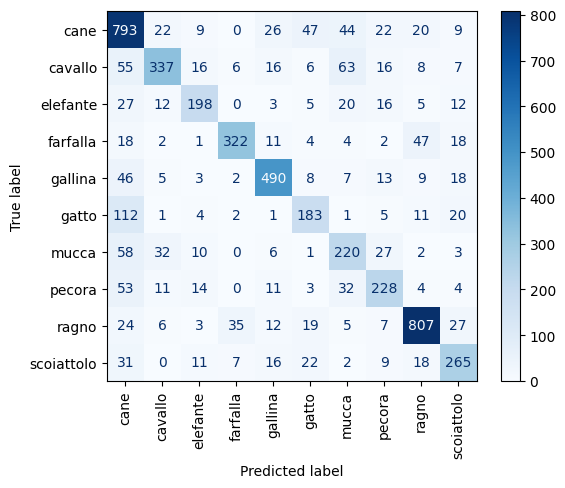

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(targets, predictions.tolist())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show() # Ensure the plot is displayed

In [111]:
top3_correct = 0
top3_preds = torch.topk(probabilities, k=3, dim=1).indices
for i in range(len(true_labels)):
    if true_labels[i] in top3_preds[i]:
        top3_correct += 1

print(f"Top-3 Accuracy: {top3_correct / len(true_labels) * 100:.2f}%")

Top-3 Accuracy: 91.84%


In [112]:
model_save_path = 'animal_cnn_model.pth'

torch.save({
    'epoch': 10, # Assuming 10 epochs were run
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # Replace with actual final train/val accuracy if available
    'train_accuracy': train_accs[-1] if train_accs else 'N/A',
    'val_accuracy': val_accs[-1] if val_accs else 'N/A',
    'num_classes': len(dataset.classes),
    'class_names': dataset.classes,
    'class_to_idx': dataset.class_to_idx,
    'model_architecture': 'custom_cnn_4_layers'
}, model_save_path)

print(f" Model saved successfully to {model_save_path}")
# Update print statement with actual final validation accuracy
print(f" Model performance: {val_accs[-1]:.2f}% validation accuracy" if val_accs else "Model performance: N/A validation accuracy")
print(f" File size: {os.path.getsize(model_save_path) / (1024*1024):.2f} MB")

 Model saved successfully to animal_cnn_model.pth
 Model performance: 73.41% validation accuracy
 File size: 298.52 MB


In [113]:
def load_trained_model(model_path, device):

    checkpoint = torch.load(model_path, map_location=device)


    num_classes = checkpoint['num_classes']
    model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(32, 64, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(64, 128, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(128, 256, 3, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Flatten(),
        torch.nn.Dropout(),
        torch.nn.Linear(256*14*14, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(),
        torch.nn.Linear(512, num_classes)
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    return model, checkpoint['class_names']

 Making predictions with confidence visualization...


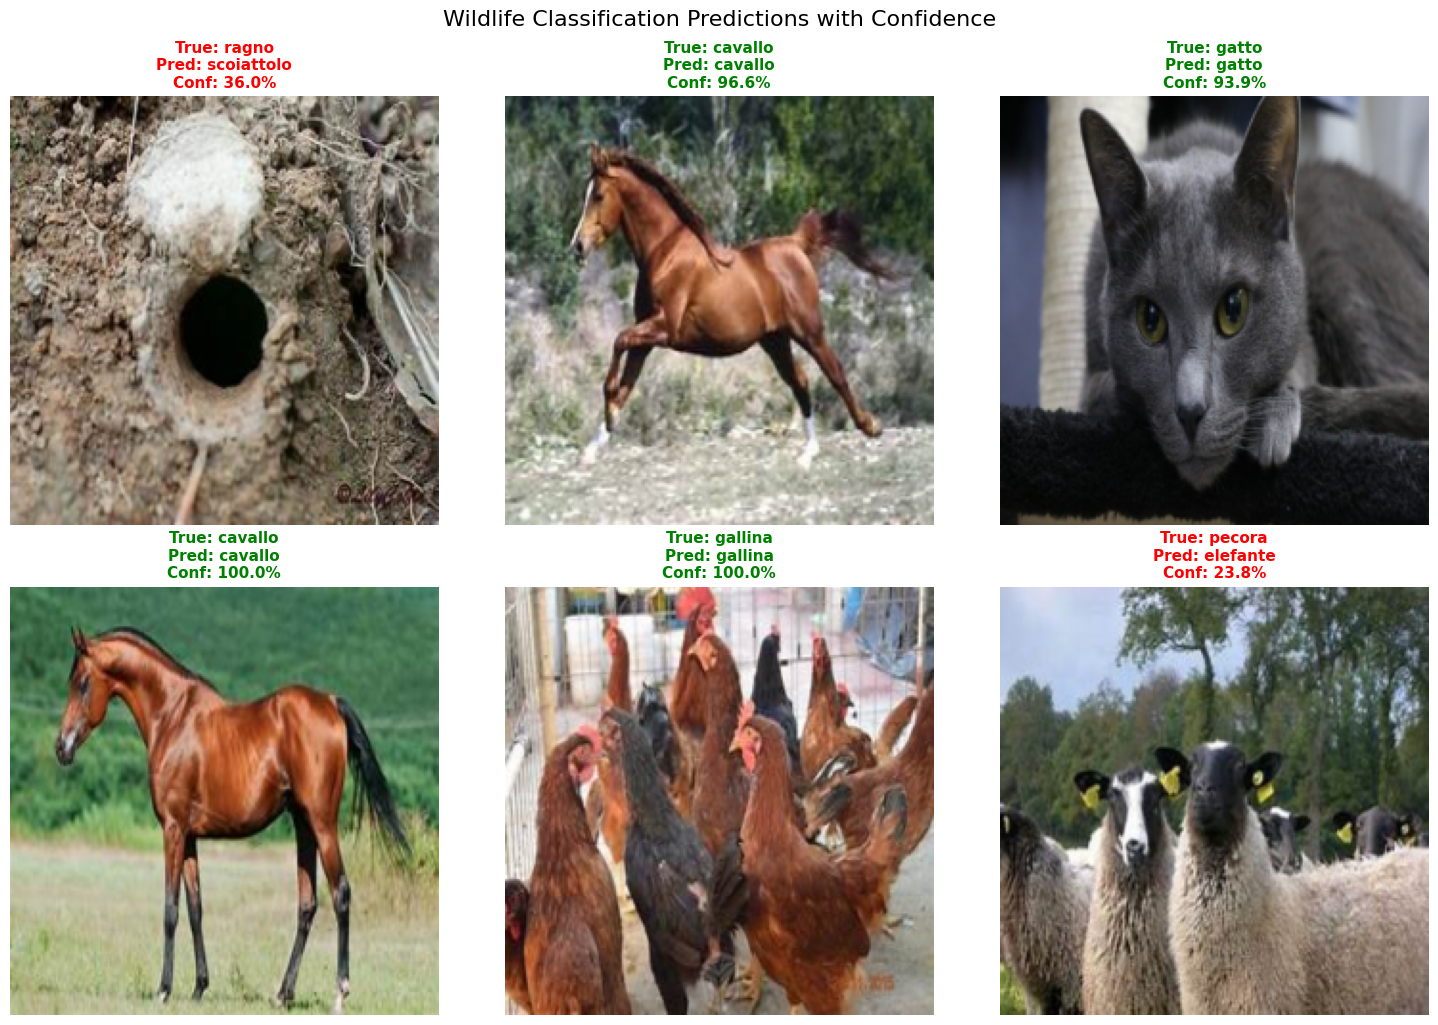

6

In [114]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
import numpy as np

def predict_and_visualize(model, val_loader, class_names, device, num_images=6):

    model.eval()
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    images_shown = 0

    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            if images_shown >= num_images:
                break

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Get predictions
            outputs = model(batch_images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, predicted = torch.max(probabilities, 1)

            # Process each image in the batch
            for i in range(min(batch_images.size(0), num_images - images_shown)):
                # Convert tensor to displayable image
                img = batch_images[i].cpu().numpy().transpose(1, 2, 0)
                # Denormalize for display (assuming imagenet normalization or similar)
                # If you used a different normalization, you might need to adjust this.
                mean = np.array([0.5177, 0.5003, 0.4125]) # Replace with your actual mean
                std = np.array([0.2659, 0.2609, 0.2784]) # Replace with your actual std
                img = std * img + mean
                img = np.clip(img, 0, 1)  # Ensure values are in [0,1] range


                true_class = class_names[batch_labels[i].item()]
                pred_class = class_names[predicted[i].item()]
                confidence = confidences[i].item()

                # Plot image
                axes[images_shown].imshow(img)

                # Color code: green for correct, red for incorrect
                title_color = 'green' if true_class == pred_class else 'red'

                # Create title with confidence
                title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1%}'
                axes[images_shown].set_title(title, color=title_color, fontsize=11, fontweight='bold')
                axes[images_shown].axis('off')

                images_shown += 1
                if images_shown >= num_images:
                    break

    plt.tight_layout()
    plt.suptitle('Wildlife Classification Predictions with Confidence', fontsize=16, y=1.02)
    plt.show()

    return images_shown

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model, class_names = load_trained_model('animal_cnn_model.pth', device)

print(" Making predictions with confidence visualization...")
predict_and_visualize(loaded_model, val_loader, class_names, device, num_images=6)

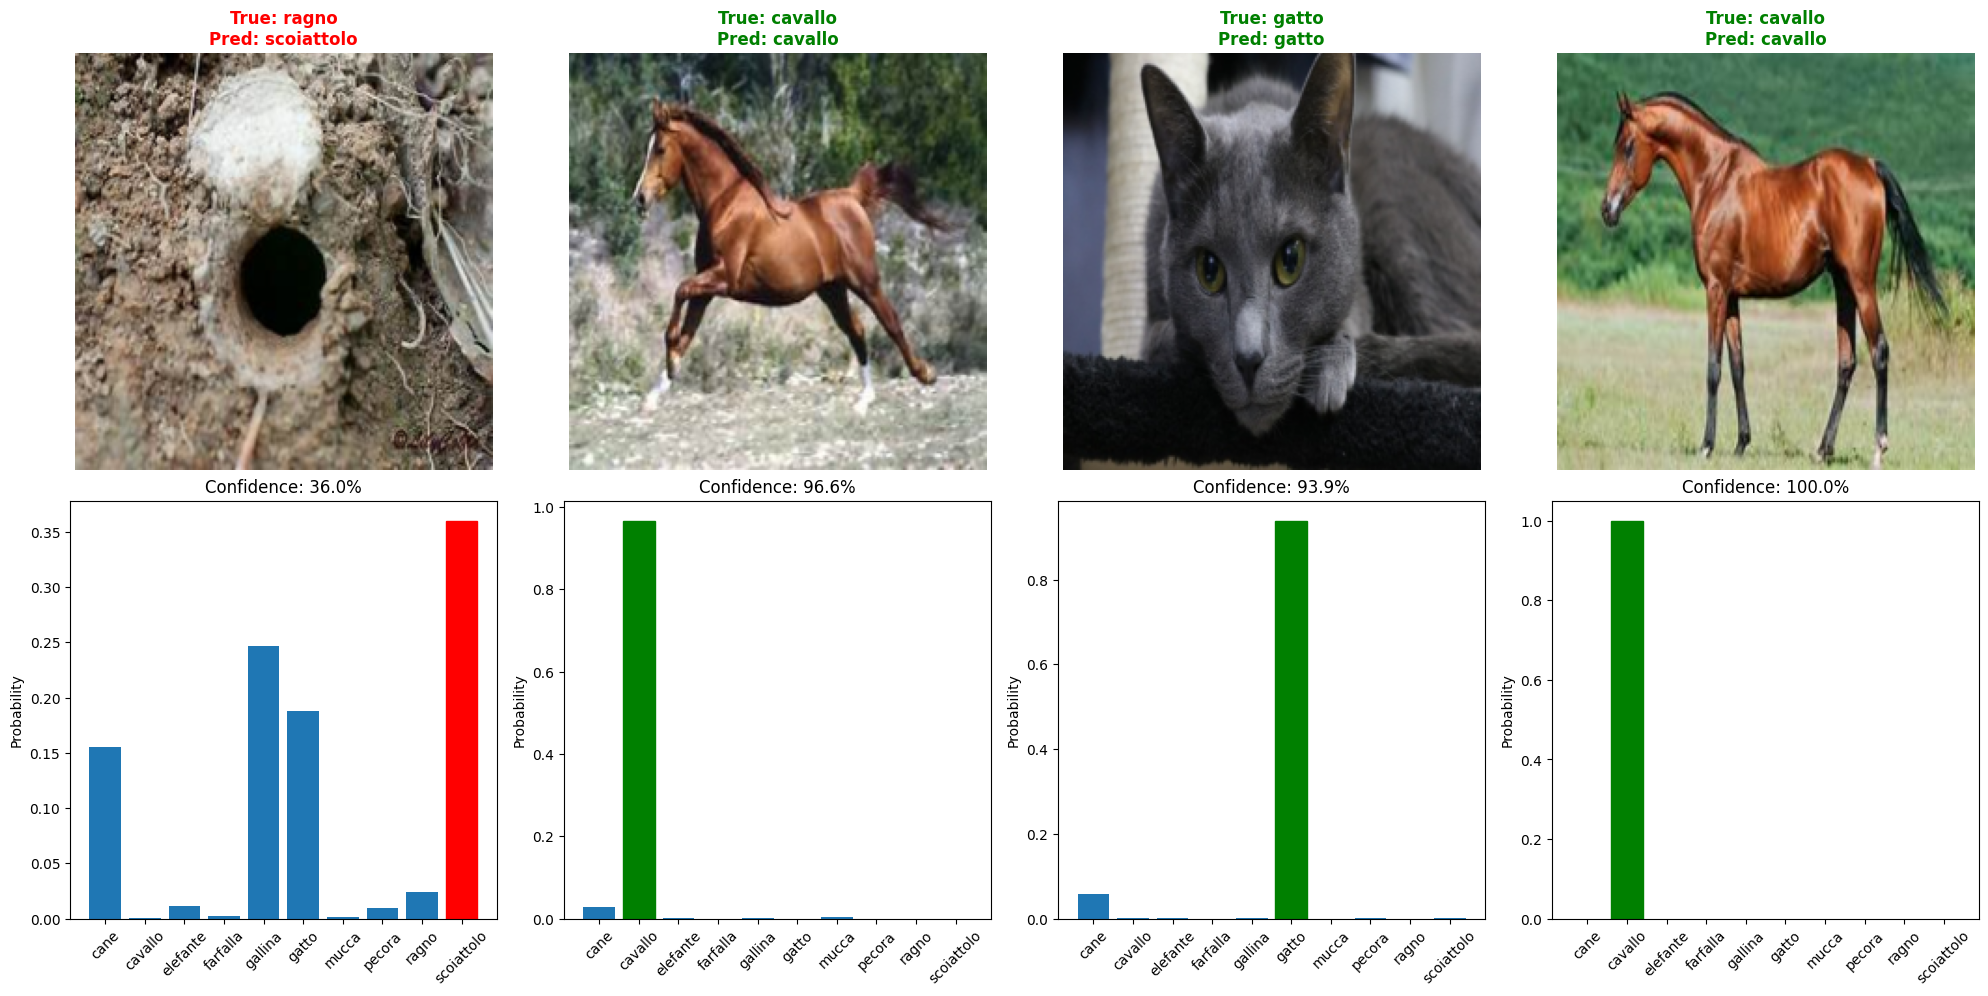

In [115]:
def predict_with_confidence_bars(model, val_loader, class_names, device, num_images=4):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    images_shown = 0

    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            if images_shown >= num_images:
                break

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_images)
            probabilities = F.softmax(outputs, dim=1)

            for i in range(min(batch_images.size(0), num_images - images_shown)):
                # Image display
                img = batch_images[i].cpu().numpy().transpose(1, 2, 0)
                # Denormalize for display
                mean = np.array([0.5177, 0.5003, 0.4125]) # Replace with your actual mean
                std = np.array([0.2659, 0.2609, 0.2784]) # Replace with your actual std
                img = std * img + mean
                img = np.clip(img, 0, 1)

                axes[0, images_shown].imshow(img)

                true_class = class_names[batch_labels[i].item()]
                pred_idx = torch.argmax(probabilities[i]).item()
                pred_class = class_names[pred_idx]
                confidence = probabilities[i][pred_idx].item()

                title_color = 'green' if true_class == pred_class else 'red'
                axes[0, images_shown].set_title(f'True: {true_class}\nPred: {pred_class}',
                                               color=title_color, fontweight='bold')
                axes[0, images_shown].axis('off')

                probs = probabilities[i].cpu().numpy()
                bars = axes[1, images_shown].bar(range(len(class_names)), probs)


                bars[pred_idx].set_color('red' if true_class != pred_class else 'green')

                axes[1, images_shown].set_title(f'Confidence: {confidence:.1%}')
                axes[1, images_shown].set_xticks(range(len(class_names)))
                axes[1, images_shown].set_xticklabels(class_names, rotation=45)
                axes[1, images_shown].set_ylabel('Probability')

                images_shown += 1
                if images_shown >= num_images:
                    break

    plt.tight_layout()
    plt.show()


predict_with_confidence_bars(loaded_model, val_loader, class_names, device, num_images=4)

In [116]:
def model_prediction_summary(model, val_loader, class_names, device):

    model.eval()
    all_preds = []
    all_labels = []
    all_confidences = []

    print(" Analyzing model predictions...")

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, predicted = torch.max(probabilities, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    avg_confidence = np.mean(all_confidences)

    print(f"PREDICTION SUMMARY")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Average Confidence: {avg_confidence:.2%}")

    # Per-class confidence
    print(f"\n📈 Average Confidence per Class:")
    for class_idx, class_name in enumerate(class_names):
        class_confidences = [all_confidences[i] for i, pred in enumerate(all_preds) if pred == class_idx]
        if class_confidences:
            print(f"  {class_name}: {np.mean(class_confidences):.2%}")

# Run prediction summary
model_prediction_summary(loaded_model, val_loader, class_names, device)

 Analyzing model predictions...


100%|██████████| 164/164 [00:23<00:00,  6.99it/s]

PREDICTION SUMMARY
Accuracy: 73.41%
Average Confidence: 79.54%

📈 Average Confidence per Class:
  cane: 76.28%
  cavallo: 78.83%
  elefante: 76.79%
  farfalla: 88.99%
  gallina: 89.88%
  gatto: 71.05%
  mucca: 72.52%
  pecora: 73.05%
  ragno: 86.91%
  scoiattolo: 69.29%


In [ ]:
!pip install torchinfo

In [ ]:
import os

# Assuming data_dir is already defined and points to the extracted dataset
raw_img_dir = os.path.join(data_dir, 'raw-img')
print(os.listdir(raw_img_dir)[:10]) # Print the first 10 items to avoid flooding the output

In [92]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

# Assuming data_dir is already defined and points to the extracted dataset
raw_img_dir = os.path.join(data_dir, 'raw-img')

# Load the dataset using the correct directory
dataset = datasets.ImageFolder(root=raw_img_dir, transform=transform_norm) # Using transform_norm
print("Image size", dataset[0][0].shape)
print("Label", dataset[0][1])
print("Number of classes:", len(dataset.classes))
print("Class names:", dataset.classes)


# Split the dataset into training and validation sets
g = torch.Generator()
g.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Train loader batches:", len(train_loader))
print("Val loader batches:", len(val_loader))

Image size torch.Size([3, 224, 224])
Label 0
Number of classes: 10
Class names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Training data set size: 20944
Validation data set size: 5235
Train loader batches: 655
Val loader batches: 164


In [91]:
# Check your current dataset structure
import os
def check_dataset_structure(root_path):
    for item in os.listdir(root_path):
        item_path = os.path.join(root_path, item)
        if os.path.isdir(item_path):
            count = len(os.listdir(item_path))
            print(f"Class '{item}': {count} images")

check_dataset_structure(os.path.join(data_dir, 'raw-img'))

Class 'cavallo': 2623 images
Class 'pecora': 1820 images
Class 'elefante': 1446 images
Class 'gatto': 1668 images
Class 'scoiattolo': 1862 images
Class 'gallina': 3098 images
Class 'ragno': 4821 images
Class 'mucca': 1866 images
Class 'cane': 4863 images
Class 'farfalla': 2112 images
